# Workshop 2: Image Classification

Image classification is the process of assigning categories to pixels of satellite or aerial images, based on their spectral characteristics, to identify different types of land cover such as forest, water or urban areas.

Geoprocesamiento 2025-1S  
Universidad Nacional de Colombia  
Authors: Alicia Arévalo Robinson and Ricardo Martinez

## 0. Requirements 🗒️

For the implementation of the code an image was created in Docker with a Python programming language available for download through __*“docker pull petebunting/au-eoed ”*__ which contains the necessary libraries and with the versions compatible and working correctly in this practical case.

### Import modules

In [3]:
# Import modules from python standard library
import os
import pprint
import random

# Import Geopandas for vector analysis (https://geopandas.org)
import geopandas

# Import the matplotlib plotting module and set it to work within
# a notebook environment.
%matplotlib inline
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Import the RSGISLib modules for the notebook
import rsgislib
import rsgislib.classification
import rsgislib.classification.classsklearn
import rsgislib.tools.filetools
import rsgislib.tools.mapping
import rsgislib.tools.plotting
import rsgislib.vectorutils
import rsgislib.zonalstats
from sklearn.ensemble import RandomForestClassifier
from rsgislib.classification.classaccuracymetrics import calc_acc_metrics_vecsamples_img
import rsgislib.classification.classxgboost

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import rsgislib.tools.plotting as rsg_plot
import rsgislib.tools.mapping as rsg_map

import pprint

# scikit-learn imports
from sklearn.model_selection import GridSearchCV

In [17]:
import rasterio
from rasterio.mask import mask
from shapely.geometry import box, mapping
from rasterio.windows import from_bounds

import pandas as pd
import geopandas as gpd
import numpy as np
from osgeo import gdal

## 1. Input data 📂

### Input raster data

**Sentinel-2 image**

**Sentinel-2 Level 2A Satellite Image**  
**ID**: COPERNICUS/S2_SR/20181230T152639_20181230T152636_T18NVG  
**Acquisition Date**: December 30, 2018  
**Platform**: Sentinel-2 (European Union/ESA Copernicus mission)  
**Processing Level**: L2A (surface reflectance, atmospherically corrected)  
**Spatial Resolutions**: 10 m, 20 m, and 60 m depending on the band  
All bands are in EPSG:32618 (UTM Zone 18N, WGS 84) 

In [124]:
input_img_full = "notebooks/Taller2/image_export3.tif"

Clip image

In [125]:
output_raster = 'notebooks/Taller2/clip_image.tif'

min_x, min_y, max_x, max_y = 400000, 130000, 470000, 200000

with rasterio.open(input_img_full) as src:
    window = from_bounds(min_x, min_y, max_x, max_y, src.transform)
    kwargs = src.meta.copy()
    kwargs.update({
        'height': window.height,
        'width': window.width,
        'transform': src.window_transform(window)
    })
    with rasterio.open(output_raster, 'w', **kwargs) as dst:
        dst.write(src.read(window=window))

In [126]:
input_img = "notebooks/Taller2/clip_image.tif"

# Check the CRS of the clipped image
with rasterio.open(input_img) as src:
    print("Raster CRS:", src.crs)

Raster CRS: EPSG:32618


Get bounding box of the image to clip data

In [127]:
img_bbox = rsgislib.imageutils.get_img_bbox(input_img)
print(img_bbox)

(400000.0, 470000.0, 130000.0, 200000.0)


Image mask generation

In [128]:

# Abrir la imagen original para obtener metadatos
with rasterio.open(input_img) as src:
    perfil = src.profile
    ancho = src.width
    alto = src.height
    bandas = src.count
    transformacion = src.transform
    crs = src.crs

# Crear una matriz de ceros con la misma forma que la imagen original
# La forma es (bandas, alto, ancho)
mascara = np.ones((alto, ancho), dtype=np.uint8)

# Actualizar el perfil para la nueva imagen
perfil.update({
    'dtype': 'uint8',
    'count': 1,  # Solo una banda
    'nodata': 0
})

# Ruta para guardar la máscara binaria
ruta_mascara = 'notebooks/Taller2/imagen_mascara.tif'

# Guardar la máscara binaria
with rasterio.open(ruta_mascara, 'w', **perfil) as dst:
    dst.write(mascara, 1)

In [129]:
in_msk_img = "notebooks/Taller2/imagen_mascara.tif" 

### Input vector data

The vector information layer corresponds to the training points that will be used for the land cover classification for the Colombian Andes and the Amazon available in the publication "A 30 m-resolution land use-land cover product for the Colombian Andes and Amazon using cloud computing"

https://www.sciencedirect.com/science/article/pii/S0303243422000149#s0060


Training data

In [132]:
vec_train_file = "notebooks/Data_geoprocessing/data/Datos_alternos.gpkg" 

lyr_names = rsgislib.vectorutils.get_vec_lyrs_lst(vec_train_file)
print(lyr_names )

['Amazontraining', 'Andestraining', 'AmazonTesting', 'AndesTesting', 'AndesTraining_']


Testing data

In [133]:
test_vec_file = "notebooks/Taller2/test.gpkg"

test_lyr_names = rsgislib.vectorutils.get_vec_lyrs_lst(test_vec_file)
print(test_lyr_names )

['test']


Read Testing and Training layers for Andes and Amazon

In [134]:
# Andes training 
andes_train= geopandas.read_file(vec_train_file, layer=lyr_names[1])
andes_train = andes_train.to_crs("EPSG:32618")

# Andes training 2
andes_train2= geopandas.read_file(vec_train_file, layer=lyr_names[4])
andes_train2 = andes_train2.to_crs("EPSG:32618")

# Amazon training
ama_train= geopandas.read_file(vec_train_file, layer=lyr_names[0])
ama_train = ama_train.to_crs("EPSG:32618")

# Andes and Amazon testing
test = geopandas.read_file(test_vec_file)
test = test.to_crs("EPSG:32618")


## 2. Data Preprocessing 🧹

Join Andes and Amazon Training layers

In [135]:
andes_ama_concat = pd.concat([andes_train, ama_train, andes_train2], ignore_index=True)
andes_ama_concat = gpd.GeoDataFrame(andes_ama_concat, geometry='geometry', crs=andes_train.crs)

Clip `test`

In [ ]:
minx, maxx, miny, maxy = img_bbox
bbox_geom = box(400000.0, 130000.0, 470000.0, 200000.0)
andes_ama_test_clipped = geopandas.clip(test, bbox_geom)
andes_ama_test_clipped.to_file("notebooks/Taller2/andes_ama_test_clip2.gpkg", driver="GPKG")

OBJECTID_1                  Name                 layer  \
110        21.0  secondary_vegetation  secondary_vegetation   
111        22.0  secondary_vegetation  secondary_vegetation   
109        20.0  secondary_vegetation  secondary_vegetation   
106        17.0  secondary_vegetation  secondary_vegetation   
107        18.0  secondary_vegetation  secondary_vegetation   
..          ...                   ...                   ...   
141        16.0          water_bodies          water_bodies   
139        14.0          water_bodies          water_bodies   
140        15.0          water_bodies          water_bodies   
65          7.0                clouds                clouds   
66          8.0                clouds                clouds   

                                                  path  \
110  C:/Users/VICTUS/Documents/MG/geoprocesamiento/...   
111  C:/Users/VICTUS/Documents/MG/geoprocesamiento/...   
109  C:/Users/VICTUS/Documents/MG/geoprocesamiento/...   
106  C:/Users/VICTUS/Documents/MG/geoprocesamiento/...   
107  C:/Users/VICTUS/Documents/MG/geoprocesamiento/...   
..                                                 ...   
141  C:/Users/VICTUS/Documents/MG/geoprocesamiento/...   
139  C:/Users/VICTUS/Documents/MG/geoprocesamiento/...   
140  C:/Users/VICTUS/Documents/MG/geoprocesamiento/...   
65   C:/Users/VICTUS/Documents/MG/geoprocesamiento/...   
66   C:/Users/VICTUS/Documents/MG/geoprocesamiento/...   

                          geometry  
110   POINT (412849.307 131573.48)  
111  POINT (412676.151 131789.926)  
109  POINT (412929.701 131845.583)  
106  POINT (421086.598 132881.429)  
107  POINT (420941.271 133008.204)  
..                             ...  
141  POINT (446040.438 176186.615)  
139  POINT (440726.396 177144.544)  
140  POINT (439047.103 180424.351)  
65   POINT (446333.957 189797.472)  
66   POINT (447050.464 195580.782)  

[111 rows x 5 columns]

Clip `andes_ama_concat`

In [138]:
minx, maxx, miny, maxy = img_bbox
bbox_geom = box(400000.0, 130000.0, 470000.0, 200000.0)
andes_ama_train_clipped = geopandas.clip(andes_ama_concat, bbox_geom)

Get properties of `andes_ama_train_train_clipped`

In [139]:
print(len(andes_ama_train_clipped))
print(andes_ama_train_clipped["Name"].value_counts())  # Check number of samples per class
print(andes_ama_train_clipped.crs)

116
Name
Artificial_surfaces     74
Agricultural areas      23
Agricultural_areas       9
Secondary vegetation     8
Water_bodies             2
Name: count, dtype: int64
EPSG:32618


Save `andes_ama_train_clipped` locally

In [140]:
andes_ama_train_clipped.to_file("notebooks/Taller2/andes_ama_train_clip2.gpkg", driver="GPKG")

Manually modify **clouds** attribute in `andes_ama_train_clipped` to get better training polygons for that class

In [141]:
# Input modified training data
andes_ama_clip_cloud= geopandas.read_file(r'notebooks/Taller2/andes_ama_train_clip.gpkg')

Rename *Agricultural_areas* to *Agricultural areas* to have a single column for that class

In [142]:
andes_ama_clip_cloud['Name'] = andes_ama_clip_cloud['Name'].replace({
    'Agricultural areas': 'Agricultural areas',
    'Agricultural_areas': 'Agricultural areas'
})
print(andes_ama_clip_cloud["Name"].unique()) 
unique_class = andes_ama_clip_cloud["Name"].unique()

['Agricultural areas' 'Clouds' 'Water_bodies' 'Artificial_surfaces'
 'Secondary vegetation']


Get properties of `andes_ama_clip_cloud`

In [144]:
print(len(andes_ama_clip_cloud))
print(andes_ama_clip_cloud["Name"].value_counts())
print(andes_ama_clip_cloud.crs)

132
Name
Artificial_surfaces     74
Agricultural areas      40
Secondary vegetation     8
Clouds                   6
Water_bodies             4
Name: count, dtype: int64
EPSG:32618


Create a vector layer for each class

In [145]:
for category in unique_class:
    # Filter geodataframe by "Name"
    andes_ama_train = andes_ama_clip_cloud[andes_ama_clip_cloud['Name'] == category]
    # Define layer name
    name_layer = str(category).replace(' ', '_').lower()
    # Save GeoPackage with new layers
    andes_ama_train.to_file(r'notebooks/Taller2/andes_ama_train_final.gpkg', layer=name_layer, driver='GPKG', mode='a')

Save GeoPakage with vector layers of each class

In [146]:
andes_ama_train="notebooks/Taller2/andes_ama_train_final.gpkg"
andes_ama_train2= geopandas.read_file(andes_ama_train)

/opt/miniconda/lib/python3.11/site-packages/pyogrio/geopandas.py:261: UserWarning: More than one layer found in 'andes_ama_train_final.gpkg': 'agricultural_areas' (default), 'clouds', 'water_bodies', 'artificial_surfaces', 'secondary_vegetation'. Specify layer parameter to avoid this warning.
  result = read_func(


Create a single map that overlays **Sentinel-2 composite** with the **training points/polygons**. The aim is to confirm that every sample truly sits on its intended land-cover type.

**Why do this?**  
Before running any machine-learning routine we need to be certain that:

1. The image subset genuinely covers every training point.  
2. No sample falls on clouds, edge artefacts, or outside the valid-pixel mask.  
3. The spectral composite looks sensible (no band shifts, correct stretch).

Image Data Size: 7000 x 7000


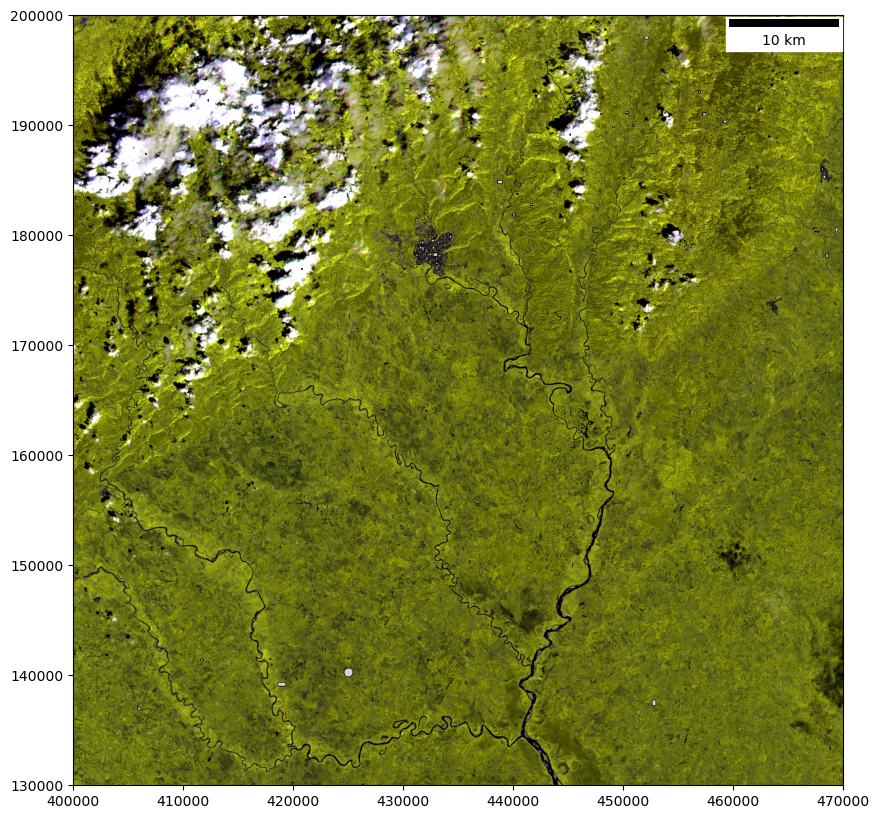

In [40]:
# Define the map window using four OSGB coordinates: xmin, xmax, ymin, ymax (metres).
sub_img_bbox = [400000.0, 470000.0, 130000.0, 200000.0]

fig, ax = plt.subplots(figsize=(10, 10))
# Draw a Sentinel-2 RGB composite
#    * input_img       : full multispectral stack
#    * img_bands       : [8 (NIR), 9 (red-edge), 3 (green)]
#    * img_stch        : cumulative histogram stretch for contrast
#    * bbox            : clip to the subset
#    * show_scale_bar  : adds a 5 km bar bottom-left
rsgislib.tools.mapping.create_raster_img_map(
    ax,
    input_img,
    img_bands=[8, 9, 3],
    img_stch=rsgislib.IMG_STRETCH_CUMULATIVE,
    bbox=img_bbox,
    show_scale_bar=True,
)

# Palette of distinct colours.
mpl_clrs = list(mcolors.CSS4_COLORS.keys())

# Lists to store GeoPandas layers and their display colours
gp_vecs  = []
lyr_clrs = []

# Load each training layer and assign a random colour
#    * lyr_names        : list of class layers in the GeoPackage
#    * vec_train_file   : path to the training samples (GPKG)
for lyr_name in lyr_names:
    # Read the class layer as a GeoDataFrame
    gp_vecs.append(andes_ama_clip_cloud)
    # Pick a random CSS colour to fill that class
    lyr_clrs.append(random.choice(mpl_clrs))

# Overlay the training vectors on the RGB image
#    * gp_vecs         : list of GeoDataFrames (one per class)
#    * vec_fill_clrs   : matching list of fill colours
#    * vec_line_clrs   : outline colour (“black” for all)
#    * bbox            : ensures vectors are clipped to the subset
#    * show_scale_bar  : False – we already drew one above
rsgislib.tools.mapping.create_vec_lyr_map(
    ax,
    gp_vecs=gp_vecs,
    bbox=sub_img_bbox,
    vec_fill_clrs=lyr_clrs,
    vec_line_clrs="black",
    show_scale_bar=False,
)


## 3. Extract training samples 🧪

Define images and bands for classification

In [147]:
img_band_info = list()
img_band_info.append(
    rsgislib.imageutils.ImageBandInfo(
        file_name=input_img, name="sen2", bands=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    )
)
print(img_band_info)

[('sen2', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'notebooks/Taller2/clip_image.tif')]


In [148]:
lyr_names2 = rsgislib.vectorutils.get_vec_lyrs_lst(r'notebooks/Taller2/andes_ama_train_final.gpkg')
print(lyr_names2)

['agricultural_areas', 'clouds', 'water_bodies', 'artificial_surfaces', 'secondary_vegetation']


Define the class and the vector samples

In [43]:
class_vec_sample_info = list()

agricultural_areas_h5 = "notebooks/Taller2/h5/agricultural_areas_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=1,
        class_name="agricultural_areas",
        vec_file=andes_ama_train,
        vec_lyr="agricultural_areas",
        file_h5=agricultural_areas_h5,
    )
)

clouds_h5 = "notebooks/Taller2/h5/clouds_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=2,
        class_name="clouds",
        vec_file=andes_ama_train,
        vec_lyr="clouds",
        file_h5=clouds_h5,
    )
)

water_bodies_h5 = "notebooks/Taller2/h5/water_bodies_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=3,
        class_name="water_bodies",
        vec_file=andes_ama_train,
        vec_lyr="water_bodies",
        file_h5=water_bodies_h5,
    )
)

artificial_surfaces_h5 = "notebooks/Taller2/h5/artificial_surfaces_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=4,
        class_name="artificial_surfaces",
        vec_file=andes_ama_train,  #vec_train_file
        vec_lyr="artificial_surfaces",
        file_h5=artificial_surfaces_h5,
    )
)

secondary_vegetation_h5 = "notebooks/Taller2/h5/secondary_vegetation_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=5,
        class_name="secondary_vegetation",
        vec_file=andes_ama_train,
        vec_lyr="secondary_vegetation",
        file_h5=secondary_vegetation_h5,
    )
)

print(class_vec_sample_info)

[<rsgislib.classification.ClassVecSamplesInfoObj object at 0x7f2272d13290>, <rsgislib.classification.ClassVecSamplesInfoObj object at 0x7f22712a2790>, <rsgislib.classification.ClassVecSamplesInfoObj object at 0x7f2271126410>, <rsgislib.classification.ClassVecSamplesInfoObj object at 0x7f22711aef10>, <rsgislib.classification.ClassVecSamplesInfoObj object at 0x7f22711ae450>]


In [44]:
obj = class_vec_sample_info[0]
vars(obj)        # returns a dictionary of attributes
# or
obj.__dict__

{'id': 1,
 'class_name': 'agricultural_areas',
 'vec_file': 'notebooks/Taller2/andes_ama_train_final.gpkg',
 'vec_lyr': 'agricultural_areas',
 'file_h5': 'notebooks/Taller2/h5/agricultural_areas_smpls.h5'}

In [45]:
tmp_dir = "notebooks/Taller2/h5"

if not os.path.exists(tmp_dir):
    os.mkdir(tmp_dir)

In [46]:
cls_smpls_info = rsgislib.classification.get_class_training_data(
    img_band_info, class_vec_sample_info, tmp_dir, ref_img=in_msk_img
)

Creating output image using input image
Running Rasterise now...

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.


Creating output image using input image

Running Rasterise now...
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.


Creating output image using input image
Running Rasterise now...

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.


Creating output image using input image

Running Rasterise now...
Get Image Min and Max.

Creating output image using input image
Running Rasterise now...
Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.




In [47]:
cls_smpls_info

{'agricultural_areas': 1: notebooks/Taller2/h5/agricultural_areas_smpls.h5, (206, 1, 104),
 'clouds': 2: notebooks/Taller2/h5/clouds_smpls.h5, (113, 129, 237),
 'water_bodies': 3: notebooks/Taller2/h5/water_bodies_smpls.h5, (249, 250, 41),
 'artificial_surfaces': 4: notebooks/Taller2/h5/artificial_surfaces_smpls.h5, (74, 210, 169),
 'secondary_vegetation': 5: notebooks/Taller2/h5/secondary_vegetation_smpls.h5, (183, 17, 238)}

Define Class Colours

In [48]:
cls_smpls_info["artificial_surfaces"].red = 180
cls_smpls_info["artificial_surfaces"].green = 180
cls_smpls_info["artificial_surfaces"].blue = 180

cls_smpls_info["agricultural_areas"].red = 131
cls_smpls_info["agricultural_areas"].green = 250
cls_smpls_info["agricultural_areas"].blue = 252

cls_smpls_info["clouds"].red = 0
cls_smpls_info["clouds"].green = 105
cls_smpls_info["clouds"].blue = 16

cls_smpls_info["water_bodies"].red = 62
cls_smpls_info["water_bodies"].green = 168
cls_smpls_info["water_bodies"].blue = 78

cls_smpls_info["secondary_vegetation"].red = 247
cls_smpls_info["secondary_vegetation"].green = 176
cls_smpls_info["secondary_vegetation"].blue = 32

cls_smpls_info

{'agricultural_areas': 1: notebooks/Taller2/h5/agricultural_areas_smpls.h5, (131, 250, 252),
 'clouds': 2: notebooks/Taller2/h5/clouds_smpls.h5, (0, 105, 16),
 'water_bodies': 3: notebooks/Taller2/h5/water_bodies_smpls.h5, (62, 168, 78),
 'artificial_surfaces': 4: notebooks/Taller2/h5/artificial_surfaces_smpls.h5, (180, 180, 180),
 'secondary_vegetation': 5: notebooks/Taller2/h5/secondary_vegetation_smpls.h5, (247, 176, 32)}

How many training samples were extracted

In [49]:
for cls_name in cls_smpls_info:
    smpls_h5_file = cls_smpls_info[cls_name].file_h5
    n_smpls = rsgislib.classification.get_num_samples(smpls_h5_file)
    print(f"{cls_name}: {n_smpls}")

agricultural_areas: 11201
clouds: 429
water_bodies: 270
artificial_surfaces: 11406
secondary_vegetation: 558


Balance and Extract Training / Validation and Testing datasets

In [50]:
# Define the output directory and create if it does not exist:
smpls_dir = "notebooks/Taller2/cls_smpls"

if not os.path.exists(smpls_dir):
    os.mkdir(smpls_dir)


cls_smpls_fnl_info = rsgislib.classification.get_class_info_dict(
    cls_smpls_info, smpls_dir
)

print("\n keys",cls_smpls_fnl_info.keys())

# print the values of artificail_surfaces
print("\n keys",cls_smpls_fnl_info["artificial_surfaces"])

0=1: (Train:notebooks/Taller2/cls_smpls/agricultural_areas_smpls_train.h5, Test:notebooks/Taller2/cls_smpls/agricultural_areas_smpls_test.h5, Valid:notebooks/Taller2/cls_smpls/agricultural_areas_smpls_valid.h5), (131, 250, 252)
1=2: (Train:notebooks/Taller2/cls_smpls/clouds_smpls_train.h5, Test:notebooks/Taller2/cls_smpls/clouds_smpls_test.h5, Valid:notebooks/Taller2/cls_smpls/clouds_smpls_valid.h5), (0, 105, 16)
2=3: (Train:notebooks/Taller2/cls_smpls/water_bodies_smpls_train.h5, Test:notebooks/Taller2/cls_smpls/water_bodies_smpls_test.h5, Valid:notebooks/Taller2/cls_smpls/water_bodies_smpls_valid.h5), (62, 168, 78)
3=4: (Train:notebooks/Taller2/cls_smpls/artificial_surfaces_smpls_train.h5, Test:notebooks/Taller2/cls_smpls/artificial_surfaces_smpls_test.h5, Valid:notebooks/Taller2/cls_smpls/artificial_surfaces_smpls_valid.h5), (180, 180, 180)
4=5: (Train:notebooks/Taller2/cls_smpls/secondary_vegetation_smpls_train.h5, Test:notebooks/Taller2/cls_smpls/secondary_vegetation_smpls_test.h5

Run the *create_train_valid_test_sets* helper function to create the **train**, **valid** and **test** datasets

In [51]:
rsgislib.classification.create_train_valid_test_sets(
    cls_smpls_info, cls_smpls_fnl_info, 27, 27, 216
)

You now have three HDF5 files for each class (look within the `cls_smpls` directory) with these defining the pixels extracted from the scene for training, validating and testing the classifier. 

If you want to see what is within one of these HDF5 files you can use the h5dump command as show below (note, when using a jupyter notebook a line starting with `!` means it will be run as a command tool rather than Python code.

Within the HDF5 file you can see the that there are 51 samples and that each as 10 values (i.e., the Sentinel-2 bands we specified to be extracted earlier). 

In [52]:
!h5dump notebooks/Taller2/cls_smpls/agricultural_areas_smpls_valid.h5

HDF5 "notebooks/Taller2/cls_smpls/agricultural_areas_smpls_valid.h5" {
GROUP "/" {
   GROUP "DATA" {
      DATASET "DATA" {
         DATATYPE  H5T_IEEE_F32LE
         DATASPACE  SIMPLE { ( 34, 10 ) / ( H5S_UNLIMITED, 10 ) }
         DATA {
         (0,0): 413, 744, 1040, 953, 1611, 2921, 3078, 3372, 3287, 5122,
         (1,0): 686, 553, 692, 634, 1404, 2825, 3395, 3332, 3746, 5938,
         (2,0): 281, 483, 848, 915, 1547, 3012, 3345, 3415, 3686, 3708,
         (3,0): 288, 464, 822, 693, 1383, 2881, 3391, 3504, 3654, 3671,
         (4,0): 268, 561, 980, 1368, 1506, 2301, 2514, 2640, 2753, 2787,
         (5,0): 268, 422, 672, 877, 1224, 1869, 2173, 2198, 2461, 2787,
         (6,0): 236, 318, 634, 449, 1084, 2623, 3257, 3385, 3561, 3516,
         (7,0): 223, 314, 542, 384, 987, 2455, 3047, 3119, 3346, 3645,
         (8,0): 234, 335, 639, 567, 1211, 2558, 2936, 3189, 3339, 3268,
         (9,0): 280, 458, 739, 649, 1215, 2654, 3160, 3262, 3614, 3427,
         (10,0): 269, 517, 678, 546, 12

## 4. Train the Classifier 🏋️ 🤖 

Optimise Classifier Parameters

In [53]:
grid_search = GridSearchCV(
    RandomForestClassifier(),
    param_grid={
        "n_estimators": [10, 20, 50, 100, 150, 200],
        "max_depth": [4, 8, 10, 12, 14, 16],
    },
)
print(grid_search )
sk_classifier = (
    rsgislib.classification.classsklearn.perform_sklearn_classifier_param_search(
        cls_smpls_fnl_info, grid_search
    )
)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [4, 8, 10, 12, 14, 16],
                         'n_estimators': [10, 20, 50, 100, 150, 200]})
Training data size: 149 x 10
Best score was 0.9393103448275862 and has parameters {'max_depth': 12, 'n_estimators': 20}.


/opt/miniconda/lib/python3.11/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Train Optimised Classifier

Now that we have the optimised classifier parameters we can train on the full dataset. 

In [54]:
rsgislib.classification.classsklearn.train_sklearn_classifier(
    cls_smpls_fnl_info, sk_classifier
)

Training data size: 1099 x 10
Testing data size: 150 x 10
Training Classifier
Completed
Calc Classifier Accuracy
Classifier Train Score = 100.0%
Classifier Test Score = 98.0%


(1.0, 0.98)

## 5. Apply Classifier 🎯

In [55]:
out_cls_img = "notebooks/Taller2/image_cls.kea"
out_scr_img = "notebooks/Taller2/image_cls_score.kea"

rsgislib.classification.classsklearn.apply_sklearn_classifier(
    cls_smpls_fnl_info,
    sk_classifier,
    in_msk_img=in_msk_img,
    img_msk_val=1,
    img_file_info=img_band_info,
    out_class_img=out_cls_img,
    gdalformat="KEA",
    class_clr_names=True,
    out_score_img=out_scr_img,
)

Applying the Classifier


  0%|          | 0/100 [00:00<?, ?it/s]

Completed
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



Calculating Image Pyramids.





Apply Colour to class 'agricultural_areas'
Apply Colour to class 'clouds'
Apply Colour to class 'water_bodies'
Apply Colour to class 'artificial_surfaces'
Apply Colour to class 'secondary_vegetation'


## 6. Visual Classification Results 🌍

Image Data Size: 7000 x 7000


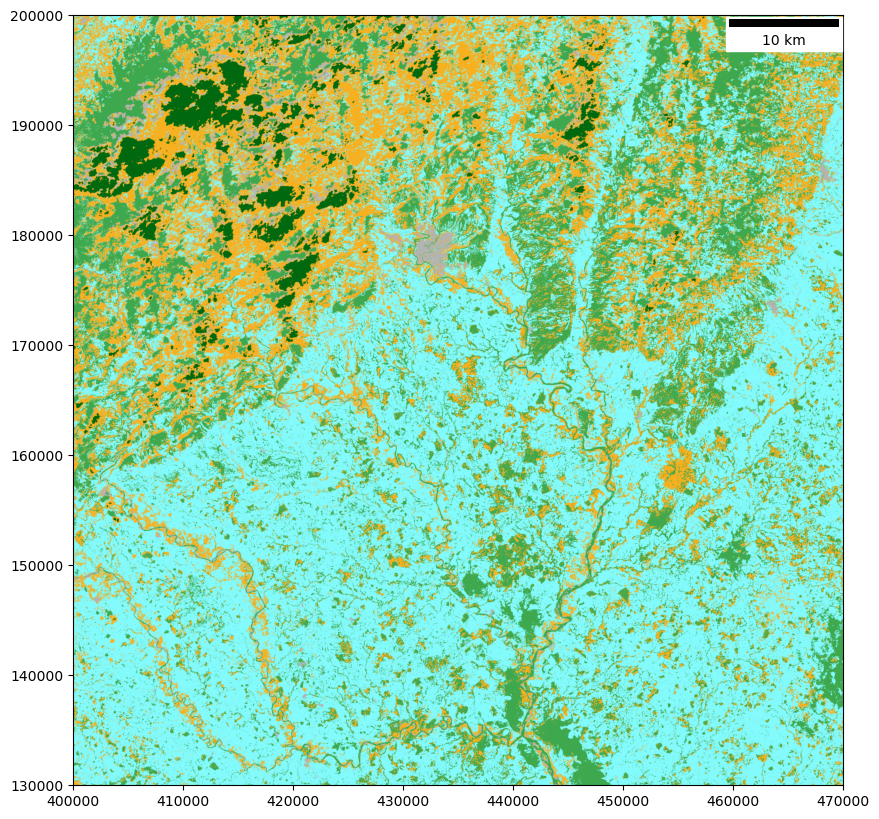

In [65]:
# Create the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 10))

rsgislib.tools.mapping.create_thematic_raster_map(ax, out_cls_img)

Visualise Subsets

Image Data Size: 7000 x 7000
Image Data Size: 7000 x 7000


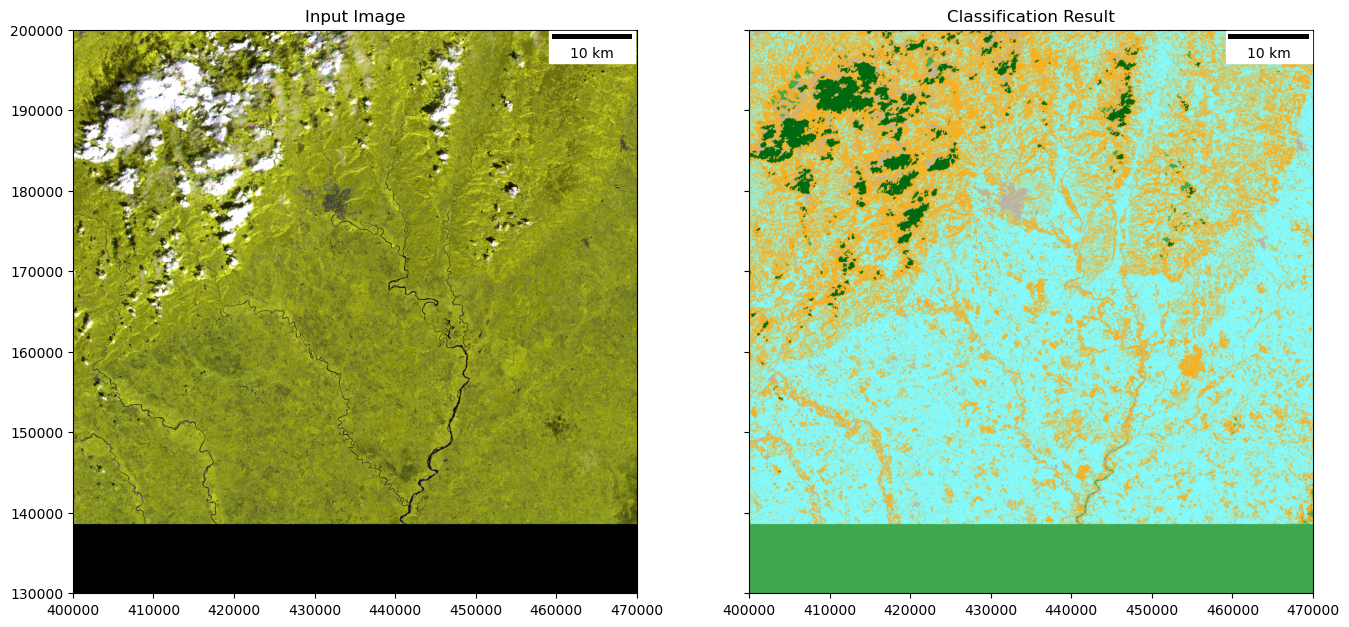

In [75]:
sub_img_bbox = [400000.0, 470000.0, 130000.0, 200000.0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Add the Sentinel-2 image to the axis
rsgislib.tools.mapping.create_raster_img_map(
    ax1,
    input_img,
    img_bands=[8, 9, 3],
    img_stch=rsgislib.IMG_STRETCH_CUMULATIVE,
    bbox=sub_img_bbox,
    show_scale_bar=True,
)
ax1.title.set_text("Input Image")

# Add the classification to the seocnd axis.
rsgislib.tools.mapping.create_thematic_raster_map(ax2, out_cls_img, bbox=sub_img_bbox)
ax2.title.set_text("Classification Result")

Create Legend

Max. characters in class name: 20
Column width: 132
Image: 276 x  82


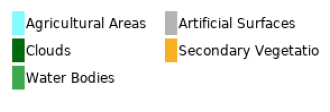

In [ ]:
# Build legend's dictionary based on raster
cls_info = rsg_plot.create_legend_info_dict(
    out_cls_img,
    cls_names_col="class_names",
    use_title_case=True,
    underscore_to_space=True,
)

# Find and choose a font for the legend
font_path = fm.findfont("DejaVu Sans", fallback_to_default=True)

# Legend
fig, ax = plt.subplots(figsize=(4, 4))

rsg_plot.create_legend_img_mpl_ax(
    ax,
    legend_info=cls_info,
    n_cols=2,          # número de columnas de la leyenda
    font=font_path,    #
)

plt.show()

Show Legend Alongside Map

Image Data Size: 7000 x 7000
Image Data Size: 7000 x 7000
Max. characters in class name: 20
Column width: 132
Image: 276 x  82


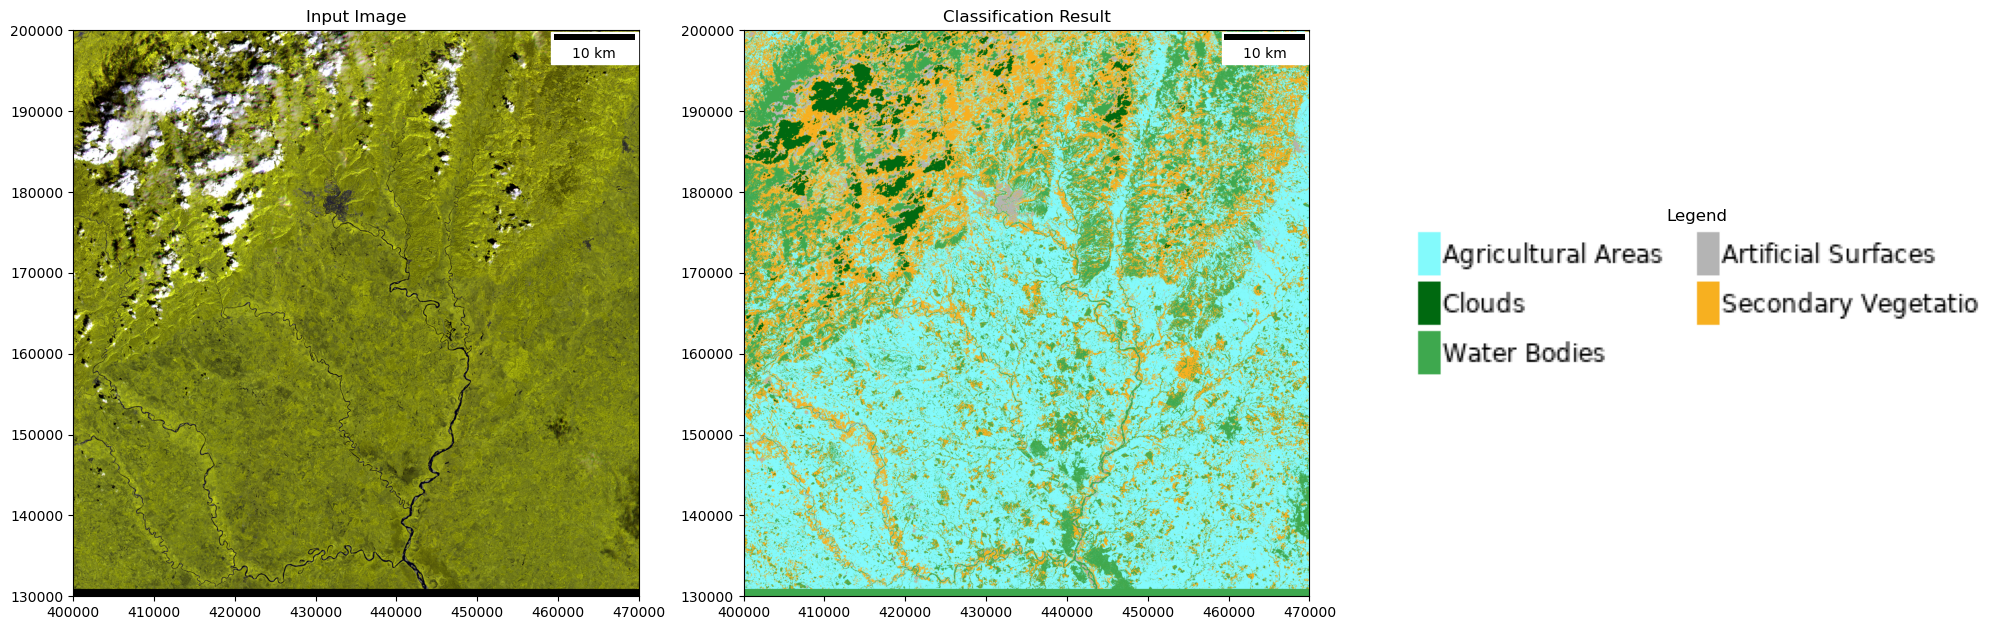

In [60]:
# 1. Legend dictionary (already created earlier as `cls_info`)
#    cls_info = rsg_plot.create_legend_info_dict(...)
# ------------------------------------------------------------

# 2. Find a reliable TrueType font (DejaVu Sans ships with Matplotlib)
font_path = fm.findfont("DejaVu Sans", fallback_to_default=True)

# 3. Build a 3-panel figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8), sharey=False)

# ---- Sentinel-2 RGB composite (bands 8-9-3) ----
rsg_map.create_raster_img_map(
    ax1,
    input_img,                       # Sentinel-2 subset (KEA / GeoTIFF)
    img_bands=[8, 9, 3],
    img_stch=rsgislib.IMG_STRETCH_CUMULATIVE,
    bbox=sub_img_bbox,
    show_scale_bar=True,
)
ax1.set_title("Input Image")

# ---- Pixel-based classification map ----
rsg_map.create_thematic_raster_map(
    ax2,
    out_cls_img,                     # Classified raster
    bbox=sub_img_bbox
)
ax2.set_title("Classification Result")

# ---- Legend panel (font argument prevents OSError) ----
rsg_plot.create_legend_img_mpl_ax(
    ax3,
    legend_info=cls_info,
    n_cols=2,                        # Columns in the legend table
    font=font_path                   # Explicit TTF path → no “cannot open resource”
)
ax3.set_title("Legend")

plt.tight_layout()
plt.show()


## 7. Accuracy metrics estimation 📈

In [149]:
test_vec_file = "notebooks/Taller2/andes_ama_test_clip2.gpkg"

test_lyr_names = rsgislib.vectorutils.get_vec_lyrs_lst(test_vec_file)
print(test_lyr_names )

test_vec_lyr = "andes_ama_test_clip2"

['andes_ama_test_clip2']


Create output Directories

In [150]:
out_pts_dir = "notebooks/Taller2/acc_pts"
if not os.path.exists(out_pts_dir):
    os.mkdir(out_pts_dir)
    
out_stats_dir = "notebooks/Taller2/acc_stats"
if not os.path.exists(out_stats_dir):
    os.mkdir(out_stats_dir)

To avoid overwriting and editting the input file provided we will first copy it into our output directory.
We also prepare a GeoJSON file containing the reference points that will be used for assessing the classification accuracy.

- `vec_refpts_file` defines the output file path for the reference points in **GeoJSON** format.
- `vec_refpts_lyr` is the name assigned to the layer within the vector file.

The function `rsgislib.vectorutils.vector_translate(...)` is used to export the specified vector layer (`vec_lyr`) from the original vector file (`vec_file`) into a new GeoJSON file (`vec_refpts_file`).  

In [151]:
vec_refpts_file = os.path.join(out_pts_dir, "test.geojson")
vec_refpts_lyr = "andes_ama_test_clip2"

rsgislib.vectorutils.vector_translate(test_vec_file, test_vec_lyr, vec_refpts_file, vec_refpts_lyr, out_format="GeoJSON", del_exist_vec=True)

Deleting: notebooks/Taller2/acc_pts/test.geojson


  1%|▉                                                                                       | 1/100 [00:00<00:06, 14.98it/s]


Read points

In [152]:
points_gdf = geopandas.read_file(vec_refpts_file)
points_gdf=points_gdf.drop(columns=['path'])
print(points_gdf["Name"].value_counts()) 
points_gdf

Name
water_bodies            30
artificial_surfaces     29
secondary_vegetation    22
agricultural_areas      20
clouds                  10
Name: count, dtype: int64


OBJECTID_1                  Name                 layer  \
0          21.0  secondary_vegetation  secondary_vegetation   
1          22.0  secondary_vegetation  secondary_vegetation   
2          20.0  secondary_vegetation  secondary_vegetation   
3          17.0  secondary_vegetation  secondary_vegetation   
4          18.0  secondary_vegetation  secondary_vegetation   
..          ...                   ...                   ...   
106        16.0          water_bodies          water_bodies   
107        14.0          water_bodies          water_bodies   
108        15.0          water_bodies          water_bodies   
109         7.0                clouds                clouds   
110         8.0                clouds                clouds   

                          geometry  
0     POINT (412849.307 131573.48)  
1    POINT (412676.151 131789.926)  
2    POINT (412929.701 131845.583)  
3    POINT (421086.598 132881.429)  
4    POINT (420941.271 133008.204)  
..                             ...  
106  POINT (446040.438 176186.615)  
107  POINT (440726.396 177144.544)  
108  POINT (439047.103 180424.351)  
109  POINT (446333.957 189797.472)  
110  POINT (447050.464 195580.782)  

[111 rows x 4 columns]

Visualising the classification reference points over the satellite image

In [ ]:
# Read image data
img_data, img_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    input_img, bands=[8, 9, 3]
)

# Stretch the image data so is visualises appropriately and usefully
# In this case the resulting values will be between 0-1.
img_data_strch = rsgislib.tools.plotting.stdev_stretch_np_arr(img_data, no_data_val=0.0)

# Create a plot using the matplotlib library
fig, ax = plt.subplots(figsize=(10, 10))
# Add the stretched image data to the plot and define the spatial
# extent so the axis labels are the coordinates.
ax.imshow(img_data_strch, extent=img_coords)

# Note. Points are randomly coloured by reference class
points_gdf.plot(ax=ax, column='ref_pts')

Image Data Size: 7000 x 7000


: 

: 

: 

Populate reference points

Using the reference points we will use the rsgislib.classification.pop_class_info_accuracy_pts function to populate the classification from cls_et_refl.kea on to these points:

In [153]:
rsgislib.classification.pop_class_info_accuracy_pts(
    input_img=out_cls_img,
    vec_file=vec_refpts_file,
    vec_lyr=vec_refpts_lyr,
    rat_class_col="class_names",
    vec_class_col="et_rl_cls",
    vec_ref_col=None,
    vec_process_col=None,
)

What has changed in the attribute table?

In [154]:
points_gdf = geopandas.read_file(vec_refpts_file)
print(len(points_gdf))
print(points_gdf["Name"].value_counts())  # Check number of samples per class
print(points_gdf.crs)

111
Name
water_bodies            30
artificial_surfaces     29
secondary_vegetation    22
agricultural_areas      20
clouds                  10
Name: count, dtype: int64
EPSG:32618


Filter Valid Points

In [155]:
vec_refpts_vld_file = os.path.join(out_pts_dir, "test_vld.geojson")
vec_refpts_vld_lyr = "test_vld"

points_gdf = points_gdf.drop(points_gdf[points_gdf["Name"] == "NA"].index)
points_gdf.to_file(vec_refpts_vld_file, driver="GeoJSON")

points_gdf

OBJECTID_1                  Name                 layer  \
0          21.0  secondary_vegetation  secondary_vegetation   
1          22.0  secondary_vegetation  secondary_vegetation   
2          20.0  secondary_vegetation  secondary_vegetation   
3          17.0  secondary_vegetation  secondary_vegetation   
4          18.0  secondary_vegetation  secondary_vegetation   
..          ...                   ...                   ...   
106        16.0          water_bodies          water_bodies   
107        14.0          water_bodies          water_bodies   
108        15.0          water_bodies          water_bodies   
109         7.0                clouds                clouds   
110         8.0                clouds                clouds   

                                                  path             et_rl_cls  \
0    C:/Users/VICTUS/Documents/MG/geoprocesamiento/...          water_bodies   
1    C:/Users/VICTUS/Documents/MG/geoprocesamiento/...          water_bodies   
2    C:/Users/VICTUS/Documents/MG/geoprocesamiento/...          water_bodies   
3    C:/Users/VICTUS/Documents/MG/geoprocesamiento/...  secondary_vegetation   
4    C:/Users/VICTUS/Documents/MG/geoprocesamiento/...          water_bodies   
..                                                 ...                   ...   
106  C:/Users/VICTUS/Documents/MG/geoprocesamiento/...          water_bodies   
107  C:/Users/VICTUS/Documents/MG/geoprocesamiento/...          water_bodies   
108  C:/Users/VICTUS/Documents/MG/geoprocesamiento/...          water_bodies   
109  C:/Users/VICTUS/Documents/MG/geoprocesamiento/...                clouds   
110  C:/Users/VICTUS/Documents/MG/geoprocesamiento/...                clouds   

                          geometry  
0     POINT (412849.307 131573.48)  
1    POINT (412676.151 131789.926)  
2    POINT (412929.701 131845.583)  
3    POINT (421086.598 132881.429)  
4    POINT (420941.271 133008.204)  
..                             ...  
106  POINT (446040.438 176186.615)  
107  POINT (440726.396 177144.544)  
108  POINT (439047.103 180424.351)  
109  POINT (446333.957 189797.472)  
110  POINT (447050.464 195580.782)  

[111 rows x 6 columns]

### Classification Metrics

- **Confusion Matrix**: shows the relationship between predicted and actual classes. For binary classification (e.g., vegetation presence vs absence), it looks like:

    |                   | Predicted: Positive | Predicted: Negative |
    |-------------------|---------------------|---------------------|
    | **Actual: Positive** | True Positive (TP)   | False Negative (FN)  |
    | **Actual: Negative** | False Positive (FP)  | True Negative (TN)   |

- **TP (True Positive):** Correctly predicted positive cases.
- **TN (True Negative):** Correctly predicted negative cases.
- **FP (False Positive):** Incorrectly predicted as positive (*commission error*).
- **FN (False Negative):** Incorrectly predicted as negative (*omission error*).

- **Precision**: The proportion of positive predictions that were actually correct.

- **Recall (Sensitivity)**: The proportion of actual positives that were correctly identified.

- **F1-Score**: The harmonic mean of precision and recall. Useful for imbalanced datasets.

- **Overall Accuracy**: The proportion of all predictions that were correct.

- **Commission Error**: The proportion of samples incorrectly assigned to a class.

- **Omission Error**: The proportion of samples that should have been assigned to a class but were not.

- **Error Types**: 

    - **Type I Error (False Positive):** Incorrectly predicting the positive class (*commission*).
    - **Type II Error (False Negative):** Failing to detect a positive case (*omission*).

- **Cohen’s Kappa (κ)**: Measures the agreement between predictions and true labels, correcting for chance agreement.

    -  **Kappa interpretation**: 

        - \( p_o \): Observed agreement (accuracy)
        - \( p_e \): Expected agreement by chance

            | Kappa Value | Interpretation         |
            |-------------|-------------------------|
            | < 0         | Poor agreement          |
            | 0.01–0.20   | Slight agreement        |
            | 0.21–0.40   | Fair agreement          |
            | 0.41–0.60   | Moderate agreement      |
            | 0.61–0.80   | Substantial agreement   |
            | 0.81–1.00   | Almost perfect agreement |


### Summary Table of Metrics

| Metric               | Formula                                     | Interpretation                                  |
|----------------------|---------------------------------------------|--------------------------------------------------|
| Precision            | $ \frac{TP}{TP + FP} $                      | Correct positive predictions / total predicted positives |
| Recall (Sensitivity) | $ \frac{TP}{TP + FN} $                      | Detected positives / actual positives           |
| F1-Score             | $ 2 \cdot \frac{P \cdot R}{P + R} $         | Balance between precision and recall            |
| Accuracy             | $ \frac{TP + TN}{TP + TN + FP + FN} $      | Overall correctness                             |
| Commission Error     | $ \frac{FP}{TP + FP} $                      | False assignments to a class                    |
| Omission Error       | $ \frac{FN}{TP + FN} $                      | Missed cases that belong to a class             |
| Kappa (κ)            | $ \frac{p_o - p_e}{1 - p_e} $               | Agreement corrected for chance                  |


Use `calc_acc_metrics_vecsamples_img` function to calculate Classification Accutacy metrics

In [156]:
out_json_file = os.path.join(out_stats_dir, "cls_acc_info.json")
out_csv_file = os.path.join(out_stats_dir, "cls_acc_info.csv")

calc_acc_metrics_vecsamples_img(
    vec_file=vec_refpts_vld_file,
    vec_lyr=vec_refpts_vld_lyr,
    ref_col="Name",
    cls_col="et_rl_cls",
    cls_img=out_cls_img,
    img_cls_name_col="class_names",
    img_hist_col="Histogram",
    out_json_file=out_json_file,
    out_csv_file=out_csv_file,
)

{np.str_('agricultural_areas'): {'precision': 0.9047619047619048,
  'recall': 0.95,
  'f1-score': 0.926829268292683,
  'support': 20.0},
 np.str_('artificial_surfaces'): {'precision': 1.0,
  'recall': 0.896551724137931,
  'f1-score': 0.9454545454545454,
  'support': 29.0},
 np.str_('clouds'): {'precision': 1.0,
  'recall': 0.7,
  'f1-score': 0.8235294117647058,
  'support': 10.0},
 np.str_('secondary_vegetation'): {'precision': 0.45454545454545453,
  'recall': 0.22727272727272727,
  'f1-score': 0.30303030303030304,
  'support': 22.0},
 np.str_('water_bodies'): {'precision': 0.6521739130434783,
  'recall': 1.0,
  'f1-score': 0.7894736842105263,
  'support': 30.0},
 'accuracy': 0.7837837837837838,
 'macro avg': {'precision': 0.8022962544701675,
  'recall': 0.7547648902821316,
  'f1-score': 0.7576634425505528,
  'support': 111.0},
 'weighted avg': {'precision': 0.7807248242030851,
  'recall': 0.7837837837837838,
  'f1-score': 0.7616300765285133,
  'support': 111.0},
 'cohen_kappa': np.flo

Export accuracy metrics values

In [ ]:
cls_acc_stats_dict = rsgislib.tools.utils.read_json_to_dict(out_json_file)
pprint.pprint(cls_acc_stats_dict)

## 8. XGBoost Classification

Create directories for outputs and intermediary files

In [64]:
out_dir = "notebooks/Taller2/baseline_cls_xgb"
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

tmp_dir = "notebooks/Taller2/tmp_xgb"
if not os.path.exists(tmp_dir):
    os.mkdir(tmp_dir)

Apply a XGBoost Multi-Class Classifier

In [ ]:
cls_info_dict = dict()
cls_info_dict["artificial_surfaces"] = rsgislib.classification.ClassInfoObj(
    id=0,
    out_id=1,
    train_file_h5=artificial_surfaces_smpls_train,
    test_file_h5=artificial_surfaces_smpls_test,
    valid_file_h5=artificial_surfaces_smpls_valid,
    red=0,
    green=255,
    blue=0,
)
cls_info_dict["agricultural_areas"] = rsgislib.classification.ClassInfoObj(
    id=1,
    out_id=2,
    train_file_h5=agricultural_areas_smpls_train,
    test_file_h5=agricultural_areas_smpls_test,
    valid_file_h5=agricultural_areas_smpls_valid,
    red=100,
    green=100,
    blue=100,
)

cls_info_dict["clouds"] = rsgislib.classification.ClassInfoObj(
    id=3,
    out_id=4,
    train_file_h5=clouds_smpls_train,
    test_file_h5=clouds_smpls_test,
    valid_file_h5=clouds_smpls_valid,
    red=0,
    green=0,
    blue=255,
)

cls_info_dict["water_bodies"] = rsgislib.classification.ClassInfoObj(
    id=4,
    out_id=5,
    train_file_h5=water_bodies_smpls_train,
    test_file_h5=water_bodies_smpls_test,
    valid_file_h5=water_bodies_smpls_valid,
    red=0,
    green=0,
    blue=255,
)

cls_info_dict["secondary_vegetation"] = rsgislib.classification.ClassInfoObj(
    id=4,
    out_id=5,
    train_file_h5=secondary_vegetation_smpls_train,
    test_file_h5=secondary_vegetation_smpls_test,
    valid_file_h5=secondary_vegetation_smpls_valid,
    red=0,
    green=0,
    blue=255,
)

Train a multi-class xgboost classifier 

In [ ]:
cls_mcls_mdl_file = os.path.join(out_dir, "xgb_mng_mcls_mdl.h5")
rsgislib.classification.classxgboost.train_opt_xgboost_multiclass_classifier(
    out_mdl_file=cls_mcls_mdl_file,
    cls_info_dict=cls_info_dict,
    op_mthd=rsgislib.OPT_MTHD_BAYESOPT,
    n_opt_iters=100,
    rnd_seed=42,
    n_threads=1,
    mdl_cls_obj=None,
    use_gpu=False,
)

Apply the multi-class classifier 

In [ ]:
out_class_img = os.path.join(out_dir, "LS5TM_19970716_mcls_img.kea")
rsgislib.classification.classxgboost.apply_xgboost_multiclass_classifier(
    model_file=cls_mcls_mdl_file,
    cls_info_dict=cls_info_dict,
    in_msk_img=vld_msk_img,
    img_msk_val=1,
    img_file_info=imgs_info,
    out_class_img=out_class_img,
    gdalformat="KEA",
    class_clr_names=True,
    n_threads=1,
)

Visualize

Accuracy metrics